In [1]:
# library Import
import pymysql
import sqlalchemy
from sqlalchemy import create_engine
import pandas as pd
import getpass
password = getpass.getpass()

········


In [2]:
# Setting up connection string
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

## Creating table for total money spent and number of rentals

In [3]:
# Customer ID # of ttl amount spent + # of Ttl Rentals
query = 'SELECT customer_id, SUM(amount) AS "Ttl_amount", \
COUNT(rental_id) AS "Ttl_rentals" FROM payment \
GROUP BY customer_id'


cust_rentals = pd.read_sql_query(query, engine)

cust_rentals.head()



,customer_id,Ttl_amount,Ttl_rentals
0,1,118.68,32
1,2,128.73,27
2,3,135.74,26
3,4,81.78,22
4,5,144.62,38


In [4]:
#Shape Check
cust_rentals.shape

(599, 3)

## Creating table for city information

In [5]:
# Setting Up City name table
querycity = 'SELECT customer.customer_id, city.city FROM customer \
INNER JOIN address ON address.address_id = customer.address_id \
INNER JOIN city ON city.city_id = address.city_id \
GROUP BY customer.customer_id'

cust_city = pd.read_sql_query(querycity,engine)

cust_city.head()

,customer_id,city
0,1,Sasebo
1,2,San Bernardino
2,3,Athenai
3,4,Myingyan
4,5,Nantou


In [6]:
#Shape Check
cust_city.shape

(599, 2)

# Creating table for most frequent rented movie category

In [7]:
# Importing customer_id, category_name, and frequency of purchase

queryrent = 'SELECT rental.customer_id, category.name AS category_name ,COUNT(*) AS freq \
FROM rental \
INNER JOIN customer ON customer.customer_id = rental.customer_id \
INNER JOIN inventory ON inventory.inventory_id = rental.inventory_id \
INNER JOIN film_category ON film_category.film_id = inventory.film_id \
INNER JOIN category ON category.category_id = film_category.category_id \
GROUP BY rental.customer_id, category_name \
ORDER BY COUNT(category.name) desc'

cust_cat = pd.read_sql_query(queryrent,engine)

cust_cat.head()


,customer_id,category_name,freq
0,469,Games,9
1,526,Animation,8
2,196,Animation,8
3,243,Documentary,8
4,506,Action,7


In [8]:
cust_cat.shape

(7741, 3)

In [9]:
 # Returning only top frequent category for each customer_id 
cust_cat.iloc[cust_cat.groupby('customer_id')['freq'].agg(pd.Series.idxmax)]

,customer_id,category_name,freq
61,1,Classics,6
272,2,Sports,5
461,3,Action,4
1810,4,Horror,3
11,5,Classics,7
...,...,...,...
641,595,Documentary,4
288,596,Sports,5
787,597,Foreign,4
1264,598,Comedy,3


In [10]:
# Creating new rental df with customer_id and their most frequent category
cust_catfreq = cust_cat.iloc[cust_cat.groupby('customer_id')['freq'].agg(pd.Series.idxmax)]

In [11]:
# Index reset
cust_catfreq = cust_catfreq.reset_index()

In [12]:
# Dropping Index and frequency columns 
cust_catfreq = cust_catfreq.drop(['index', 'freq'], axis = 1)

In [13]:
# Header Check
cust_catfreq.head()

,customer_id,category_name
0,1,Classics
1,2,Sports
2,3,Action
3,4,Horror
4,5,Classics


## Creating table for number of movies rented in previous month

In [14]:
#Importing data for last month rentals 
querylstmonth = 'SELECT rental.customer_id, rental_date, \
CASE \
	WHEN rental_date BETWEEN 20050515 AND 20050530 THEN COUNT(*) \
    ELSE 0 \
END AS last_month_rentals \
FROM rental \
GROUP BY rental.customer_id'

cust_Lstmth = pd.read_sql_query(querylstmonth, engine)

cust_Lstmth.head()

,customer_id,rental_date,last_month_rentals
0,1,2005-05-25 11:30:37,32
1,2,2005-05-27 00:09:24,27
2,3,2005-05-27 17:17:09,26
3,4,2005-06-15 09:31:28,0
4,5,2005-05-29 07:25:16,38


In [15]:
cust_Lstmth.shape

(599, 3)

In [16]:
# Dropping date 'rental_date' column
cust_Lstmnth = cust_Lstmth.drop(['rental_date'], axis = 1)

In [17]:
# Importing active for current month (1 = 'yes' 0 = 'no')
querycurrentactive = 'SELECT rental.customer_id, rental_date, \
CASE \
	WHEN rental_date BETWEEN 20050615 AND 20050630 THEN 1 \
    ELSE 0 \
END AS current_month_active \
FROM rental \
GROUP BY rental.customer_id'

cust_active = pd.read_sql_query(querycurrentactive, engine)

cust_active.head()


,customer_id,rental_date,current_month_active
0,1,2005-05-25 11:30:37,0
1,2,2005-05-27 00:09:24,0
2,3,2005-05-27 17:17:09,0
3,4,2005-06-15 09:31:28,1
4,5,2005-05-29 07:25:16,0


In [18]:
# shape check
cust_active.shape

(599, 3)

In [19]:
# dropping date column
cust_active = cust_active.drop(['rental_date'], axis = 1)

## Combining all tables

In [20]:
# Merge 1 => merging rental + city information
merge1 = pd.merge(cust_rentals, cust_city, on = 'customer_id')
merge1.head()

,customer_id,Ttl_amount,Ttl_rentals,city
0,1,118.68,32,Sasebo
1,2,128.73,27,San Bernardino
2,3,135.74,26,Athenai
3,4,81.78,22,Myingyan
4,5,144.62,38,Nantou


In [21]:
# Merge 2 => merging rental + city + most frequent category information
merge2 =  pd.merge(merge1, cust_catfreq, on = 'customer_id')
merge2.head()                          

,customer_id,Ttl_amount,Ttl_rentals,city,category_name
0,1,118.68,32,Sasebo,Classics
1,2,128.73,27,San Bernardino,Sports
2,3,135.74,26,Athenai,Action
3,4,81.78,22,Myingyan,Horror
4,5,144.62,38,Nantou,Classics


In [22]:
# Merge 3 => merging rental + city + most frequent category information + last month rentals
merge3 = pd.merge(merge2, cust_Lstmnth, on = 'customer_id')
merge3.head()

,customer_id,Ttl_amount,Ttl_rentals,city,category_name,last_month_rentals
0,1,118.68,32,Sasebo,Classics,32
1,2,128.73,27,San Bernardino,Sports,27
2,3,135.74,26,Athenai,Action,26
3,4,81.78,22,Myingyan,Horror,0
4,5,144.62,38,Nantou,Classics,38


In [23]:
# Full merge => merging rental + city + most frequent category information + last month rentals + active
finaldf = pd.merge(merge3, cust_active, on = 'customer_id')

finaldf.head()

,customer_id,Ttl_amount,Ttl_rentals,city,category_name,last_month_rentals,current_month_active
0,1,118.68,32,Sasebo,Classics,32,0
1,2,128.73,27,San Bernardino,Sports,27,0
2,3,135.74,26,Athenai,Action,26,0
3,4,81.78,22,Myingyan,Horror,0,1
4,5,144.62,38,Nantou,Classics,38,0


## Prediction Model

In [24]:
# Importing other relevant libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style="whitegrid"

In [25]:
# Data exploration
print("The dataframe has {} rows and {} columns".format(finaldf.shape[0],finaldf.shape[1]))
print()
print("The data types of each column of the dataframe are:")
print(finaldf.dtypes)
print()

The dataframe has 599 rows and 7 columns

The data types of each column of the dataframe are:
customer_id               int64
Ttl_amount              float64
Ttl_rentals               int64
city                     object
category_name            object
last_month_rentals        int64
current_month_active      int64
dtype: object



In [26]:
# Converting current_month_active and customer_id to categorical
finaldf['customer_id'] = finaldf['customer_id'].astype('object')

In [27]:
# Checking of numerical columns
finaldf.dtypes

customer_id              object
Ttl_amount              float64
Ttl_rentals               int64
city                     object
category_name            object
last_month_rentals        int64
current_month_active      int64
dtype: object

In [28]:
# Finding NA's 
print("The number of NA's in the dataframe is: ")
print(finaldf.isna().sum())
print()

The number of NA's in the dataframe is: 
customer_id             0
Ttl_amount              0
Ttl_rentals             0
city                    0
category_name           0
last_month_rentals      0
current_month_active    0
dtype: int64



The categorical columns are:  ['customer_id', 'city', 'category_name']

Frequency analysis of column:  customer_id

Frequency analysis of column:  city

Frequency analysis of column:  category_name



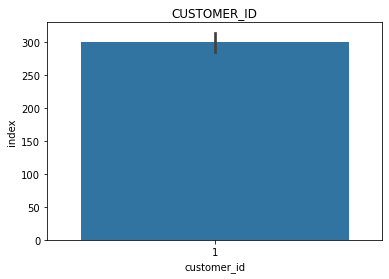

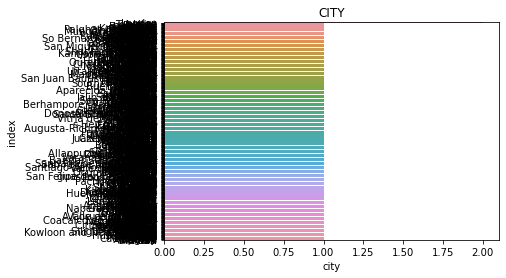

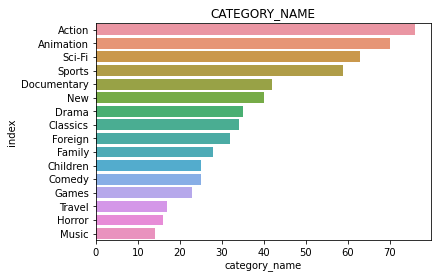

<Figure size 432x288 with 0 Axes>

In [29]:
# checking of categorical columns
cols_cat = list(finaldf.select_dtypes(include=['object']).columns)

print("The categorical columns are: ",cols_cat)
print("========================================")
print()

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = finaldf[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print()

In [30]:
#Drop city column
finaldf = finaldf.drop(['city'], axis = 1)

In [31]:
# Dummifying categorical columns
cat = finaldf.select_dtypes(include = np.object)
categorical = pd.get_dummies(cat, columns=['category_name'],drop_first=True)
categorical.head()

,customer_id,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


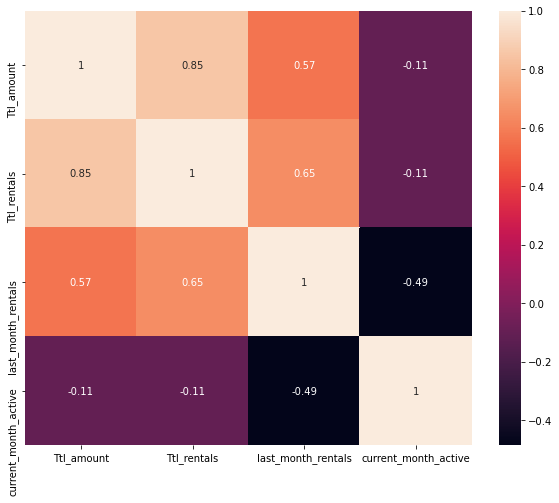

In [41]:
# Check for multicollinearity (Pearson)
corr_matrix = finaldf.corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()


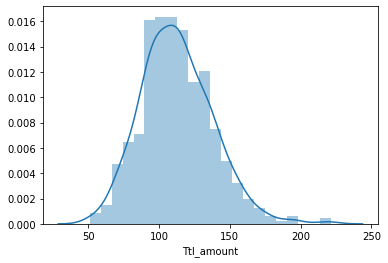

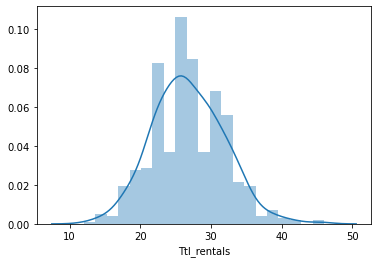

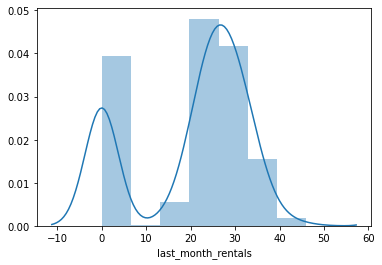

In [33]:
# Checking for distribution of numericals
sns.distplot(finaldf['Ttl_amount'])
plt.show()

sns.distplot(finaldf['Ttl_rentals'])
plt.show()

sns.distplot(finaldf['last_month_rentals'])
plt.show()


Low level of skewness 

In [34]:
# Standardizing model - Importing libraries
from sklearn.preprocessing import StandardScaler

X1 = finaldf.drop(['current_month_active'], axis =1).select_dtypes(include = np.number)

In [35]:
# Standaardizing numerical columns
transformer = StandardScaler().fit(X1)
x_standardized = transformer.transform(X1)
x_standardized = pd.DataFrame(x_standardized)

In [42]:
# Applying Model using standadized + dummified categoricals

y = finaldf['current_month_active']
X = np.concatenate((x_standardized, categorical), axis = 1)

In [37]:
print(X1)

     Ttl_amount  Ttl_rentals  last_month_rentals
0        118.68           32                  32
1        128.73           27                  27
2        135.74           26                  26
3         81.78           22                   0
4        144.62           38                  38
..          ...          ...                 ...
594      117.70           30                  30
595       96.72           28                  28
596       99.75           25                  25
597       83.78           22                   0
598       83.81           19                   0

[599 rows x 3 columns]


In [43]:
categorical.head()

,customer_id,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# Import of Xtesttrain/Ytesttrain
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [45]:
# Importing Logistic Regression
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

C:\Users\sogun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
from sklearn.metrics import accuracy_score

predictions = classification.predict(X_test)

The accuracy of the model on test set is: 0.83 
[[187  21]
 [ 20  12]]


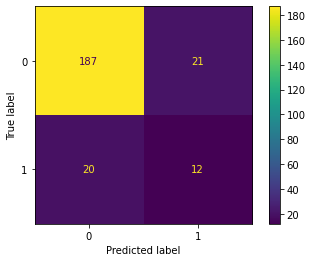

The Kappa of your model is: 0.27


In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))